# Bayesian Repertoire Overlap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from scipy.stats import hypergeom
from scipy.stats import binned_statistic as binsta
from scipy.special import logsumexp
from util import *
import palettable as pal
clrx = pal.cartocolors.qualitative.Prism_10.mpl_colors
clr = tuple(x for n,x in enumerate(clrx) if n in [1,2,4,5,6])
clr2 = pal.cartocolors.sequential.agSunset_7.mpl_colors

## Simulation

In [2]:
# CCP, the Coupon Collector's Problem
def ccp_sample(c,pool=60):
    return len(set(np.random.choice(pool,c)))

In [3]:
# Draw overlap
def nab_sample(s,na,nb,pool=60):
    sa = np.random.hypergeometric(s,pool-s,na)
    nab = np.random.hypergeometric(sa,pool-sa,nb)
    return nab

In [4]:
# Overlap between two PCRs of depth c and overlap s
def pcr_sample(c,s):
    na = ccp_sample(c)
    nb = ccp_sample(c)
    return nab_sample(s,na,nb),na,nb

## Theory

In [5]:
def p_ccp(c, pool=60):
    p = np.zeros([c+1,pool+1])
    p[0,0] = 1;
    for row in range(1,c+1):
        for k in range(1,np.min([row+2,pool+1])):
            p[row,k] = p[row-1,k]*k/pool + p[row-1,k-1]*(1-(k-1)/pool)
    return p[-1,:]

In [6]:
def p_overlap(na,nb,nab,pool=60):
    p_s = np.zeros(pool+1)
    # reference: hypergeom.pmf(outcome, Total, hits, Draws, loc=0)
    for s in np.arange(pool+1):
        # p_sa is the probabiltiy that we'd get sa from the overlap (s), just in na draws of a
        p_sa = hypergeom.pmf(np.arange(pool+1),pool,s,na)
        # p_nab_given_sa is the probability of getting that nab, given sa
        p_nab_given_sa = hypergeom.pmf(nab,pool,np.arange(pool+1),nb)
        p_s[s] = np.dot(p_sa,p_nab_given_sa)
    return p_s/np.sum(p_s)

In [7]:
def e_overlap(na,nb,nab,pool=60):
    p_s = p_overlap(na,nb,nab,pool=pool)
    return np.dot(np.arange(pool+1),p_s)

In [8]:
def credible_interval(na,nb,nab,pct=90,pool=60):
    p_s = p_overlap(na,nb,nab,pool=pool)
    cdf = np.cumsum(p_s)
    ccdf = np.flipud(np.cumsum(np.flipud(p_s)))
    # adjust for fractions vs percents; put everything as a fraction
    if pct > 1:
        pct = pct/100
    cutoff = (1-pct)/2
    # get the lower bound. 
    # it's the first index at which cdf ≥ cutoff
    try:
        lower = np.where(cdf >= cutoff)[0][0]
    except IndexError:
        lower = 0
    # get the upper bound
    # it's the first index at which ccdf ≥ 0.05
    try:
        upper = np.where(ccdf >= cutoff)[0][-1]
    except IndexError:
        upper=pool
    expectation = np.dot(np.arange(pool+1),p_s)
    # Sanity and indexing check: uncomment this line to see true tail probability ≤ 0.05
    # print([cdf[lower-1],(1-ccdf[upper+1])])
    return lower,expectation,upper

In [9]:
def p_nab_given_c(s,c,pool=60):
    pna = p_ccp(c)
    pnb = p_ccp(c)
    nas = np.arange(1,len(pna))
    nbs = np.arange(1,len(pnb))
    p_gen = np.zeros([pool+1,pool+1,pool+1])
    for na in nas:
        p_sa = hypergeom.pmf(np.arange(pool+1),pool,s,na)
        for nb in nbs:
            pna_pnb = pna[na] * pnb[nb]
            for nab in range(0,np.minimum(na,nb)):
                p_nab_given_sa = hypergeom.pmf(nab,pool,np.arange(pool+1),nb)
                p_nab_given_s = np.dot(p_sa,p_nab_given_sa)
                p_gen[na,nb,nab] = p_nab_given_s * pna_pnb
    return p_gen

In [10]:
def p_shat_given_sc(s,c,shat,pool=60):
    masses = p_nab_given_c(s,c,pool=pool)
    if np.sum(masses)<0.99:
        print('Swapping to Monte Carlo')
        return p_shat_given_sc_montecarlo(s,c,shat,pool=pool)
    hist = binsta(np.ravel(shat),np.ravel(masses),statistic='sum',bins=(np.arange(pool+2)-0.5))
    return hist

In [11]:
def p_shat_given_sc_montecarlo(s,c,shat,pool=60,n_mc=int(1e5)):
    masses = np.zeros([pool+1,pool+1,pool+1])
    for ii in range(n_mc):
        nab,na,nb = pcr_sample(c,s)
        masses[na,nb,nab] += 1
    hist = binsta(np.ravel(shat),np.ravel(masses/n_mc),statistic='sum',bins=(np.arange(pool+2)-0.5))
    return hist

In [12]:
def compute_all_estimates(pool=60):
    shat = np.zeros([pool+1,pool+1,pool+1])
    for na in range(1,pool+1):
        for nb in range(1,pool+1):
            for nab in range(0,np.minimum(na+1,nb+1)):
                shat[na,nb,nab] = e_overlap(na,nb,nab,pool=pool)
    return shat

In [13]:
# shat = compute_all_estimates(pool=60)
# np.save('shat_60.npy',shat)
shat = np.load('shat_60.npy')

## Manuscript calculations

Suppose that $s=20$ sequences are shared between two repertoires, and that the repertoires are sampled at rates $n_a=21$ and $n_b=16$.  What is the distribution of PTS estimates?

In [31]:
nabs = np.zeros(1000)
na = 37
nb = 24
for ii in range(1000):
    nabs[ii] = nab_sample(s=30,na=na,nb=nb,pool=60)
pts = 2*nabs/(na+nb)
print("Mean PTS is {:.3f} when true overlap fraction is 0.5.".format(np.mean(pts)))

Mean PTS is 0.243 when true overlap fraction is 0.5.


How many possible calculations are there?

In [79]:
ctr = 0
for na in range(1,61):
    for nb in range(1,61):
        for nab in range(np.min([na,nb])+1):
            ctr +=1
print("There are {} possible combinations of na, nb, and nab.".format(ctr))

There are 77410 possible combinations of na, nb, and nab.


For how many of these is PTS less than BRO?

In [85]:
ctrr = 0
for na in range(1,61):
    for nb in range(1,61):
        for nab in range(np.min([na,nb])+1):
            pts = 120*nab/(na+nb)
            bro = shat[na,nb,nab]
            if (bro >= pts):
                ctrr +=1
            else:
                print(na,nb,nab)
print("There are {} combinations of na, nb, and nab where BRO ≥ PTS.".format(ctrr))
print("This covers {:.3f}% of cases.".format(ctrr*100/ctr))

1 1 1
2 2 2
2 3 2
3 2 2
3 3 3
3 4 3
4 3 3
4 4 4
4 5 4
5 4 4
5 5 5
5 6 5
6 5 5
6 6 6
6 7 6
7 6 6
7 7 7
7 8 7
8 7 7
8 8 8
8 9 8
9 8 8
9 9 9
9 10 9
10 9 9
10 10 10
10 11 10
11 10 10
11 11 11
11 12 11
12 11 11
12 12 12
12 13 12
13 12 12
13 13 13
13 14 13
14 13 13
14 14 14
14 15 14
15 14 14
15 15 15
15 16 15
16 15 15
16 16 16
16 17 16
17 16 16
17 17 17
17 18 17
18 17 17
18 18 18
18 19 18
19 18 18
19 19 19
19 20 19
20 19 19
20 20 20
20 21 20
21 20 20
21 21 21
21 22 21
22 21 21
22 22 22
22 23 22
23 22 22
23 23 23
23 24 23
24 23 23
24 24 24
24 25 24
25 24 24
25 25 25
25 26 25
26 25 25
26 26 26
26 27 26
27 26 26
27 27 27
27 28 27
28 27 27
28 28 28
28 29 28
29 28 28
29 29 29
30 30 30
31 31 31
32 32 32
33 33 33
34 34 34
35 35 35
36 36 36
37 37 37
38 38 38
39 39 39
40 40 40
41 41 41
42 42 42
43 43 43
44 44 44
45 45 45
46 46 46
47 47 47
48 48 48
49 49 49
50 50 50
51 51 51
52 52 52
53 53 53
54 54 54
55 55 55
56 56 56
57 57 57
58 58 58
59 59 59
There are 77297 combinations of na, nb, and nab where BR

## Tests

### Test 0: Show a posterior

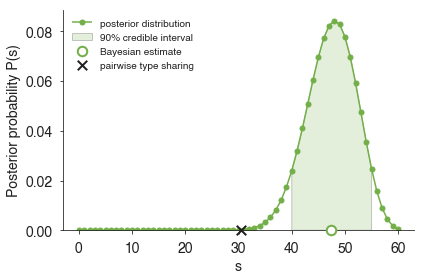

In [67]:
na = 47
nb = 32
nab = 20
pool = 60

pts = pool*2*nab/(na+nb)
ps = p_overlap(na,nb,nab,pool=pool)
lower,shat,upper = credible_interval(na,nb,nab,pool=pool)
x = np.arange(lower,upper+1)
y = np.copy(ps[x])
x = np.append(x,upper)
y = np.append(y,0)
x = np.insert(x,0,lower)
y =np.insert(y,0,0)
er =np.zeros([2,1])
er[0] = shat-lower
er[1] = upper-shat

fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(np.arange(pool+1),ps,
        label='posterior distribution',
        linestyle='-',
        marker='o',
        ms=5,
        color = clr[2])

ax.scatter(shat,0,
           facecolor=[1,1,1],
           edgecolor=clr[2],
           linewidth = 2,
                s=90,
           marker='o',
           label='Bayesian estimate',
          clip_on=False,zorder=100)

ax.fill(x,y,
        facecolor=clr[2],
        edgecolor=[0,0,0],
        alpha=0.2,
        label='90% credible interval',)

ax.scatter(pts,0,
        linewidth=2,
        color=ALMOST_BLACK_V,
        marker='x',
                s=90,
        label='pairwise type sharing',
       clip_on=False,zorder=100)

ax.set_ylim(bottom=0)
ax.legend()
plt.ylabel('Posterior probability P(s)')
plt.xlabel('s')
finalize(ax)
plt.tight_layout()
plt.savefig('figures/posterior_example.pdf')
# plt.show()

### Test 1: recovery accuracy as sampling increases

In [16]:
pool=60
shat = np.load('shat_60.npy')

In [128]:
reps=4
recovered = np.zeros([6,reps,pool+1])
planted = np.zeros([6,reps,pool+1])
recovered_pts = np.zeros([6,reps,pool+1])
nas = [20,30,40,50,60]
for idxa,na in enumerate(nas):
    nb = na
    for s in np.arange(0,pool+1,1):
        for rep in range(3):
            nab = nab_sample(s,na,nb)
            planted[idxa,rep,s] = s
            recovered[idxa,rep,s] = e_overlap(na,nb,nab)
            recovered_pts[idxa,rep,s] = 2*nab/(na+nb)

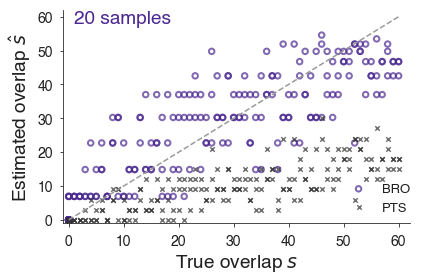

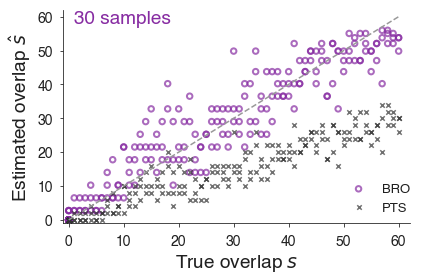

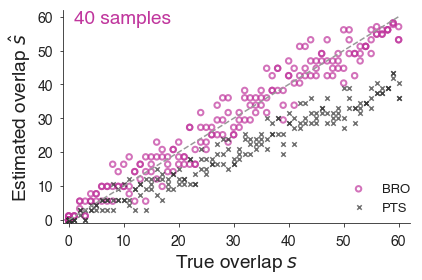

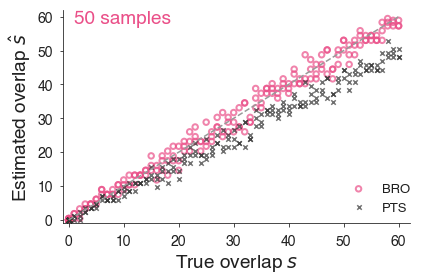

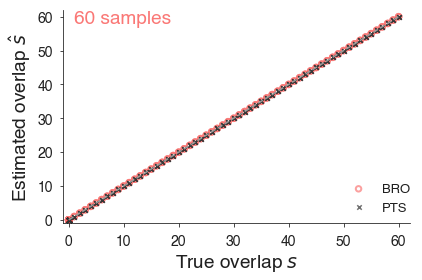

In [138]:
for idxa,na in enumerate(nas):
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.plot([0,60],[0,60],color=[0.6,0.6,0.6],
#             label='reference',
            linestyle='--')
    ax.scatter(planted[idxa,:,:],recovered[idxa,:,:],
               label='BRO'.format(na),
               edgecolor = clr2[idxa],
               facecolor = 'none',
               linewidth = 2,
               s = 30,
               alpha = 0.7,
              )
    ax.scatter(planted[idxa,:,:],pool*recovered_pts[idxa,:,:],
               label='PTS',
               c = [0.2,0.2,0.2],
               marker = 'x',
               s = 20,
               alpha = 0.7,
              )
    ax.axis([-1, pool+2, -1, pool+2])
    ax.legend()
    plt.ylabel('Estimated overlap $\hat s$'.format(na))
    plt.xlabel('True overlap $s$')
    finalize(ax)
    leg = ax.legend(loc=[0.8,0.02],frameon=False,fontsize=13)
    ax.yaxis.label.set_size(19)
    ax.xaxis.label.set_size(19)
    ax.text(1, 58, '{} samples'.format(na), fontsize=19,color=clr2[idxa])
    plt.tight_layout()
    plt.savefig('figures/bayes_pts_{}.pdf'.format(na))
    plt.show()

### Test 2: Credible Intervals

In [75]:
pool=60
shat = np.load('shat_60.npy')
planted2 = np.zeros([6,6,pool+1])
recovered2 = np.zeros([6,6,pool+1])
lower = np.zeros([6,6,pool+1])
upper = np.zeros([6,6,pool+1])

nas = [20,30,40,50,60]
for idxa,na in enumerate(nas):
    nb = na
    idxb = idxa
    for s in np.arange(0,pool+1,1):
        planted2[idxa,idxb,s] = s
        nab = nab_sample(s,na,nb)
        lower[idxa,idxb,s], recovered2[idxa,idxb,s], upper[idxa,idxb,s] = credible_interval(na,nb,nab)
        es = e_overlap(na,nb,nab)
        recovered2[idxa,idxb,s] = es

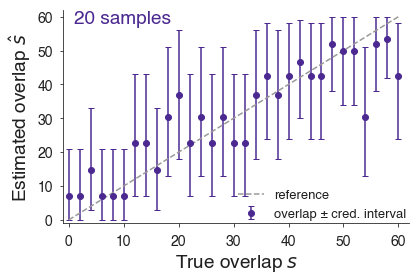

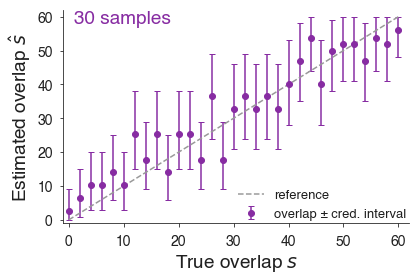

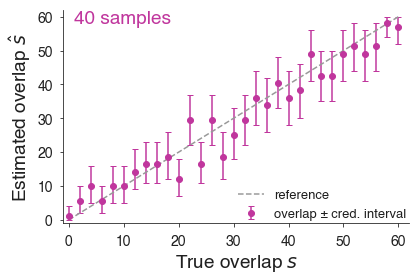

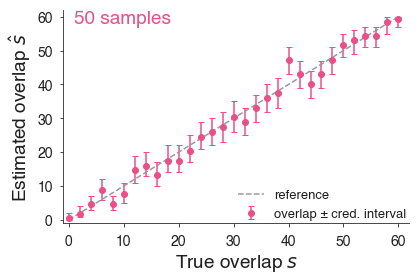

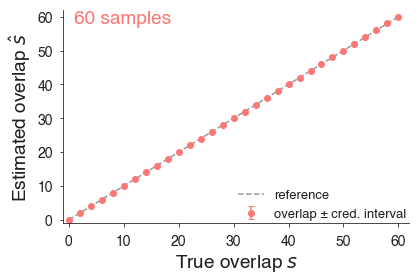

In [139]:
sub = np.arange(0,pool+1,2)
for idxa,na in enumerate(nas):
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.errorbar(planted2[idxa,idxa,sub],recovered2[idxa,idxa,sub],
               yerr = [recovered2[idxa,idxa,sub]-lower[idxa,idxa,sub],upper[idxa,idxa,sub]-recovered2[idxa,idxa,sub]],  
               label='overlap ± cred. interval',
               c = clr2[idxa],
                capsize=3,
                fmt='o',
              )
    ax.plot([0,60],[0,60],color=[0.6,0.6,0.6],
            label='reference',
            linestyle='--')
    ax.axis([-1, pool+2, -1, pool+2])
    plt.ylabel('Estimated overlap $\hat s$')
    plt.xlabel('True overlap $s$')
    finalize(ax)
    leg = ax.legend(loc=[0.49,-0.01],frameon=False,fontsize=13)
    ax.yaxis.label.set_size(19)
    ax.xaxis.label.set_size(19)
    ax.text(1, 58, '{} samples'.format(na), fontsize=19,color=clr2[idxa])
    plt.tight_layout()
    plt.savefig('figures/cred_reg_{}.pdf'.format(na))
    plt.show()

### Test 3: Distribution of errors from PCR

In [141]:
shat = np.load('shat_60.npy')
hist_error = {}
pool = 60
ss = [10,20,30,40,50]
cc = [48,96,144]

In [142]:
for c in cc:
    hist_error[c] = np.zeros([len(ss),pool+1])
    for idx,s in enumerate(ss):
        hist_error[c][idx,:] = np.array(p_shat_given_sc(s,c,shat)[0])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


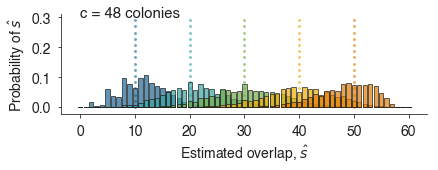

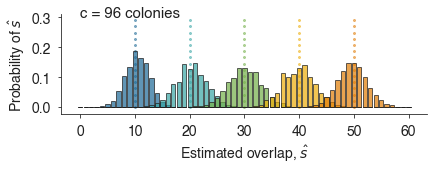

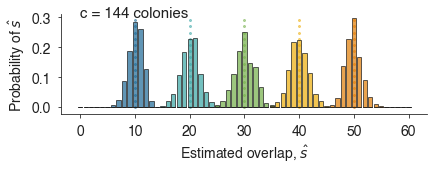

In [143]:
for idc,c in enumerate(cc):
    fig,ax = plt.subplots(1,1,figsize=(6,2.3))
    for idx,s in enumerate(ss):
        ax.scatter(s*np.ones(15),np.linspace(0,0.29,15),4,alpha=0.5, color=clr[idx])
    for idx,s in enumerate(ss):
        ax.bar(np.arange(pool+1),hist_error[c][idx],
              color = clr[idx],
#                label='true s={}'.format(s),
               alpha=0.7,
               ec = ALMOST_BLACK_V
              )
        ax.set_xlabel('Estimated overlap, $\hat{s}$')
        ax.set_ylabel('Probability of $\hat{s}$')
        ax.set_ylim(top=0.31)
        ax.set_yticks(np.array([0.0,0.1,0.2,0.3]))
#         scx = ax.get_xlim()[1]
#         scy = ax.get_ylim()[1]
# ARROWS - decided against these.        
#     for idx,s in enumerate(ss):
#         ax.annotate("", xy=(s, 0), xytext=(s+0.05*scx, 0.15*scy),
#             arrowprops=dict(
#             facecolor=ALMOST_BLACK_V,
#                 width=1,
#             headwidth=6,
#             shrink=0.05))
    ax.text(0, 0.30, 'c = {} colonies'.format(c), fontsize=15)
    plt.tight_layout()
    if idc==0:
        finalize(ax)
        ax.legend(loc=[0.65,0.30],frameon=False)        
    else:
        finalize(ax,ignoreLegend=True)
    plt.savefig('figures/s_hat_PCR_c{}.pdf'.format(c))
    plt.show()

# Distributions of errors from PCR vs c

In [24]:
hist_error_2 = {}
ss = [30]
pool = 60
cc = [48,96,144,192]

In [25]:
for c in cc:
    hist_error_2[c] = np.zeros([len(ss),pool+1])
    for idx,s in enumerate(ss):
        hist_error_2[c][idx,:] = np.array(p_shat_given_sc(s,c,shat)[0])

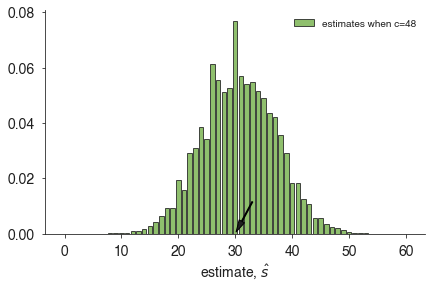

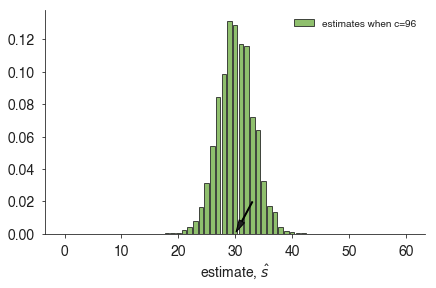

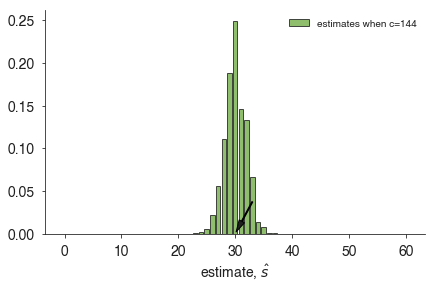

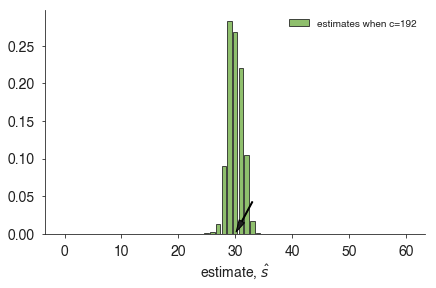

In [26]:
for c in cc:
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    for idx,s in enumerate(ss):
        ax.bar(np.arange(pool+1),hist_error_2[c][idx],
              color = clr[2],
               label='estimates when c={}'.format(c),
               alpha = 0.8,
               ec = ALMOST_BLACK_V
              )
        plt.xlabel('estimate, $\hat{s}$')
        scx = ax.get_xlim()[1]
        scy = ax.get_ylim()[1]
    for idx,s in enumerate(ss):
        ax.annotate("", xy=(s, 0), xytext=(s+0.05*scx, 0.15*scy),
            arrowprops=dict(
            facecolor=ALMOST_BLACK_V,
                width=1,
            headwidth=6,
            shrink=0.05))
    plt.tight_layout()
    finalize(ax)
    plt.savefig('figures/s_hat_PCR_s{}_c{}.pdf'.format(s,c))
    plt.show()

# Fix PTS and vary parameters

We know that we have
$$PTS = \frac{2 n_{ab}}{n_a + n_b}$$

If we fix $PTS=0.5$, then we have $\frac{1}{2} = \frac{2 n_{ab}}{n_a + n_b}$ and this means that 
$$n_a + n_b = 4 n_{ab}$$

In [27]:
fixedpts_nab = 20
for na in np.arange(20,41):
    print(shat[na,80-na,20])

58.18181818181819
56.536707056307925
55.058333333333344
53.72813559322035
52.53050397877985
51.452241715399595
50.48214285714286
49.610658307210024
48.829629629629636
48.132075471698116
47.51201923076923
46.96434937611407
46.484705882352934
46.069387755102035
45.715277777777786
45.41978148361126
45.180778032036635
44.9965811965812
44.865909090909085
44.78786159954625
44.76190476190476


# Reprocess past studies

In [14]:
bro = {}
pts = {}
lci = {}

def lenci(na,nb,nab):
    lower,expectation,upper = credible_interval(na,nb,nab,pool=60)
    return upper-lower+1

Amele (Barry et al 2007; using data from SI of Albrecht et al 2010)

In [15]:
dfAme_all = pd.read_excel('data/amele.XLS').replace('-',0)
dfAme = dfAme_all.loc[dfAme_all["source"]=="AMELE"]
dfAme = dfAme.iloc[:,:len(dfAme)]

n = len(dfAme)-1
nab = dfAme.values.astype(int)
na = np.diagonal(nab)
dummy = []
dummz = []
dummp = []
for a in np.arange(n-1):
    for b in np.arange(a+1,n):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["ame"] = np.array(dummy)
pts["ame"] = np.array(dummz)
lci["ame"] = np.array(dummp)
print("Mean samples per parasite: {:.1f}".format(np.mean(na[:n])))

Mean samples per parasite: 15.6


Kilifi (Bull et al 2007; using data from SI of Albrecht et al 2010)

In [16]:
dfKil = pd.read_excel('data/kilifi.xlsx').replace('-',0)
n = len(dfKil)-1
na = np.array(dfKil.loc[n].apply(lambda x: 60 if x>60 else x)).astype(int)
nab = dfKil.values.astype(int)
dummy = []
dummz = []
dummp = []
# note that this file needs a and b swapped to get the lower diagonal
for a in np.arange(1,n):
    for b in np.arange(0,a):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b])) 
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["kilifi"] = np.array(dummy)
pts["kilifi"] = np.array(dummz)
lci["kilifi"] = np.array(dummp)

Brazil (Albrecht 2010)

In [17]:
dfBra = pd.read_excel('data/allbrazil.xlsx').replace('-',0)
n = len(dfBra)-1
na = np.array(dfBra.loc[n].apply(lambda x: 60 if x>60 else x)).astype(int)
nab = dfBra.values.astype(int)
dummy = []
dummz = []
dummp = []
for a in np.arange(n-1):
    for b in np.arange(a+1,n):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["brazil"] = np.array(dummy)
pts["brazil"] = np.array(dummz)
lci["brazil"] = np.array(dummp)

Ariquemes 1  (Albrecht 2010)

In [18]:
pars = ["113","121","122","123","127","128","153","154"]
dfAri = pd.read_excel('data/ariquemes_1.xlsx').replace('-',0)

n = len(dfAri)-1
na = np.array(dfAri.loc[n].apply(lambda x: 60 if x>60 else x)).astype(int)
nab = dfAri.values.astype(int)

dummy = []
dummz = []
dummp = []

q = np.zeros(np.shape(nab),dtype=int)

for par in pars:
    cols = [col for col in dfAri.columns if par in col]
    ida = list(dfAri.columns).index(cols[0])
    idz = ida+len(cols)
    for a in np.arange(ida,idz):
        for b in np.arange(a+1,idz):
            q[a,b] = 1
            dummy.append(shat[na[a],na[b],nab[a,b]])
            dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
            dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["ari"] = np.array(dummy)
pts["ari"] = np.array(dummz)
lci["ari"] = np.array(dummp)

Ariquemes 2  (Albrecht 2010)

In [19]:
dfAri2 = pd.read_excel('data/ariquemes_2.xlsx').replace('-',0)
n = len(dfAri2)-1
na = np.array(dfAri2.loc[n].apply(lambda x: 60 if x>60 else x)).astype(int)
nab = dfAri2.values.astype(int)
dummy = []
dummz = []
dummp = []
for a in np.arange(n):
    for b in np.arange(a+1,n-1):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["ari2"] = np.array(dummy)
pts["ari2"] = np.array(dummz)
lci["ari2"] = np.array(dummp)

Wosera (Tessema et al 2014)

In [20]:
dfWos = pd.read_excel('data/tessema_wosera.xlsx')
# compute na, the number of sequences per parasite
na = dfWos.sum().values
# number of parasites
n = len(na)
# compute nab, the number of shared sequences for each pair of parasites
pars = list(dfWos)
nab = np.zeros([n,n],dtype=int)
for a,para in enumerate(pars):
    for b,parb in enumerate(pars):
        nab[a,b] = np.sum((dfWos[para]+dfWos[parb])==2)
dummy = []
dummz = []
dummp = []
for a in np.arange(n):
    for b in np.arange(a+1,n-1):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["wosera"] = np.array(dummy)
pts["wosera"] = np.array(dummz)
lci["wosera"] = np.array(dummp)

Amele (data from SI of Tessema et al 2014)

In [21]:
dfAme2 = pd.read_excel('data/tessema_amele.xlsx')
# compute na, the number of sequences per parasite
na = dfAme2.sum().values
# number of parasites
n = len(na)
# compute nab, the number of shared sequences for each pair of parasites
pars = list(dfAme2)
nab = np.zeros([n,n],dtype=int)
for a,para in enumerate(pars):
    for b,parb in enumerate(pars):
        nab[a,b] = np.sum((dfAme2[para]+dfAme2[parb])==2)
dummy = []
dummz = []
dummp = []
for a in np.arange(n):
    for b in np.arange(a+1,n-1):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["amele_tessema"] = np.array(dummy)
pts["amele_tessema"] = np.array(dummz)
lci["amele_tessema"] = np.array(dummp)

Mugil (Tessema et al 2014)

In [22]:
dfMug = pd.read_excel('data/tessema_mugil.xlsx')
# compute na, the number of sequences per parasite
na = dfMug.sum().values
# number of parasites
n = len(na)
# compute nab, the number of shared sequences for each pair of parasites
pars = list(dfMug)
nab = np.zeros([n,n],dtype=int)
for a,para in enumerate(pars):
    for b,parb in enumerate(pars):
        nab[a,b] = np.sum((dfMug[para]+dfMug[parb])==2)
dummy = []
dummz = []
dummp = []
for a in np.arange(n):
    for b in np.arange(a+1,n-1):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["mugil"] = np.array(dummy)
pts["mugil"] = np.array(dummz)
lci["mugil"] = np.array(dummp)

Bei et al PPAT 2018

In [23]:
dfThies = pd.read_csv('data/bei_ppat.csv')
n = len(dfThies)-1
na = np.array(dfThies.loc[n].apply(lambda x: 60 if x>60 else x)).astype(int)
nab = dfThies.values.astype(int)
dummy = []
dummz = []
dummp = []
for a in np.arange(n):
    for b in np.arange(a+1,n-1):
        dummy.append(shat[na[a],na[b],nab[a,b]])
        dummz.append(60*2*nab[a,b]/(na[a]+na[b]))
        dummp.append(lenci(na[a],na[b],nab[a,b]))
bro["thies"] = np.array(dummy)
pts["thies"] = np.array(dummz)
lci["thies"] = np.array(dummp)
print("Mean samples per parasite: {:.1f}".format(np.mean(na[:n])))

Mean samples per parasite: 36.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.


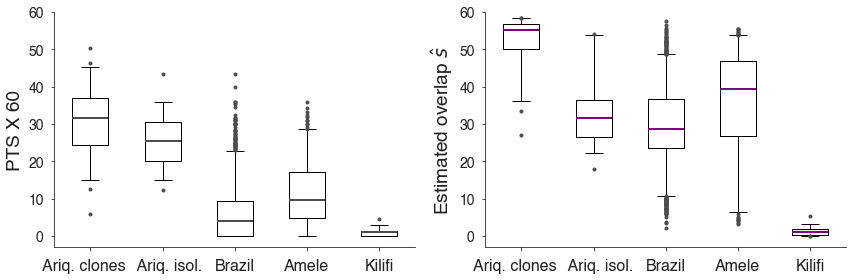

In [168]:
sc = 1
thr = [61,61,15]
samples = ["ari","ari2","brazil","ame","kilifi"]
[pts[x] for x in samples]
colors = [[0.3,0.3,0.3],"purple","red"]

fig,axs = plt.subplots(1,2,figsize=(12,4))
dat = [pts,bro,bro]
titles = ["PTS", "BRO"]
for idx,ax in enumerate(axs):
    fp = dict(marker='.',markerfacecolor=[0.3,0.3,0.3],markeredgecolor=[0.3,0.3,0.3])
    mp = dict(linestyle='-', linewidth=2, color=colors[idx])
    ax.boxplot([dat[idx][x][lci[x]<=thr[idx]]/sc for x in samples],whis=[2.5,97.5],flierprops=fp, medianprops=mp)
#     ax.violinplot([dat[idx][x][lci[x]<61]/sc for x in samples])
    if sc == 60:
        ax.set_ylim([-0.05,1.0])
    else:
        ax.set_ylim([-3,60])
    finalize(ax)
    ax.set_xticklabels(["Ariq. clones   ","   Ariq. isol.","Brazil","Amele","Kilifi"],size=16)
    ax.yaxis.label.set_size(19)
    ax.xaxis.label.set_size(19)
axs[0].set_ylabel('PTS X 60')
axs[1].set_ylabel('Estimated overlap $\hat{s}$')
plt.tight_layout()
plt.savefig('figures/albrecht2010remake.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


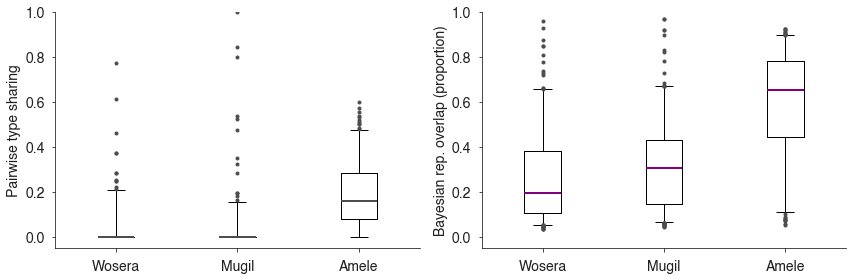

In [380]:
sc = 60
thr = [61,61,15]
samples = ["wosera","mugil","amele_tessema"]
[pts[x] for x in samples]
colors = [[0.3,0.3,0.3],"purple","red"]

fig,axs = plt.subplots(1,2,figsize=(12,4))
dat = [pts,bro,bro]
titles = ["PTS", "BRO"]
for idx,ax in enumerate(axs):
    fp = dict(marker='.',markerfacecolor=[0.3,0.3,0.3],markeredgecolor=[0.3,0.3,0.3])
    mp = dict(linestyle='-', linewidth=2, color=colors[idx])
    ax.boxplot([dat[idx][x][lci[x]<=thr[idx]]/sc for x in samples],whis=[2.5,97.5],flierprops=fp, medianprops=mp)
#     ax.violinplot([dat[idx][x][lci[x]<61]/sc for x in samples])
    if sc == 60:
        ax.set_ylim([-0.05,1.0])
    else:
        ax.set_ylim([0,60/sc])
    ax.set_xticklabels(["Wosera","Mugil","Amele"])
    finalize(ax)
axs[0].set_ylabel('Pairwise type sharing')
axs[1].set_ylabel('Bayesian rep. overlap (proportion)')
plt.tight_layout()
plt.savefig('figures/tessema2015remake.pdf')

In [189]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

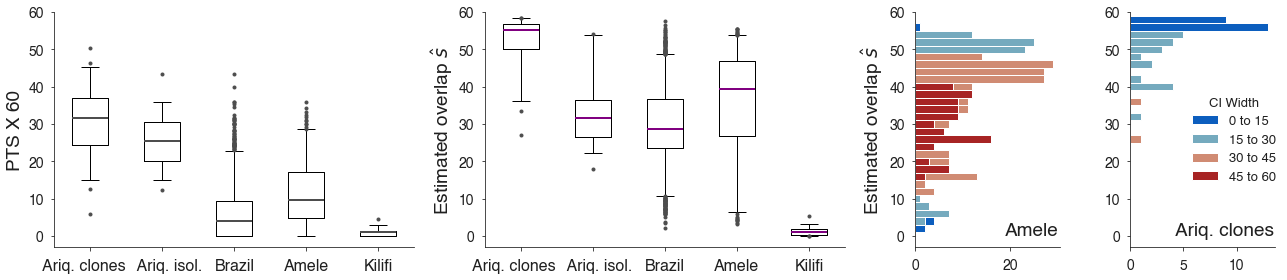

In [228]:
sc = 1
thr = [61,61,15]
samples = ["ari","ari2","brazil","ame","kilifi"]
[pts[x] for x in samples]
colors = [[0.3,0.3,0.3],"purple","red"]
clr3 = pal.cmocean.diverging.Balance_7.mpl_colors
clr3[3] = clr3[4]
clr3[4] = clr3[5]
bands = np.arange(0,46,15)
bands = np.transpose(np.array([bands,bands+15]))

fig = plt.figure(figsize=(18,4))
gs = gridspec.GridSpec(1,6)
ax1 = plt.subplot(gs[0,0:2])
ax2 = plt.subplot(gs[0,2:4])
ax8 = plt.subplot(gs[0,4])
ax9 = plt.subplot(gs[0,5])

axs = [ax1,ax2]
dat = [pts,bro]
for idx,ax in enumerate(axs):
    fp = dict(marker='.',markerfacecolor=[0.3,0.3,0.3],markeredgecolor=[0.3,0.3,0.3])
    mp = dict(linestyle='-', linewidth=2, color=colors[idx])
    ax.boxplot([dat[idx][x][lci[x]<=thr[idx]]/sc for x in samples],whis=[2.5,97.5],flierprops=fp, medianprops=mp)
    if sc == 60:
        ax.set_ylim([-0.05,1.0])
    else:
        ax.set_ylim([-3,60])
    finalize(ax,ignoreLegend=True)
    ax.set_xticklabels(["Ariq. clones   ","   Ariq. isol.","Brazil","Amele","Kilifi"],size=16)
    ax.yaxis.label.set_size(19)
    ax.xaxis.label.set_size(19)
axs[0].set_ylabel('PTS X 60')
axs[1].set_ylabel('Estimated overlap $\hat{s}$')

bxs = [ax8,ax9]

samples = ["ame","ari"]
names = ["Amele", "Ariq. clones"]
ds=2
subs = [sax2,sax3]
for ids,sample in enumerate(samples):
    ax = bxs[ids]
    df = pd.DataFrame(data={"bro":bro[sample], "unc":lci[sample]})
    for idx,b in enumerate(bands):
        h = np.histogram(df.loc[(df["unc"]>b[0]) & (df["unc"]<=b[1]),"bro"].values,
                         bins=(np.arange(0,63,ds)-0.5))[0]
        ax.barh(np.arange(0,61,ds),h,2,color=clr3[idx+1],
                edgecolor='white',label="{} to {}".format(b[0],b[1]))
    if ids==0:
        finalize(ax,ignoreLegend=True)
    else:
        finalize(ax,ignoreLegend=True)
        leg = ax.legend(frameon=False,title="CI Width",
                        loc=[0.39,0.25],
                        fontsize=13)
        plt.setp(leg.get_title(),fontsize=13)
    ax.yaxis.label.set_size(19)
    ax.xaxis.label.set_size(19)   
    ax.set_ylim(ax1.get_ylim())
    
yscale = ax9.get_ylim()
ax8.set_ylabel(ax2.get_ylabel())
ax8.text(0.62*ax8.get_xlim()[1],0.05*(yscale[1]-yscale[0])+yscale[0],"{}".format(names[0]),size=19)
ax9.text(0.31*ax9.get_xlim()[1],0.05*(yscale[1]-yscale[0])+yscale[0],"{}".format(names[1]),size=19)

# # Create a Rectangle patch
# rect = patches.Rectangle((3.65,0),0.7,yscale[1],linewidth=2,edgecolor='None',
#                          facecolor=[0.1,0.5,0.5],alpha=0.1,
#                         zorder=-999)
# ax2.add_patch(rect)
# # Create a Rectangle patch
# rect = patches.Rectangle((0.65,0),0.7,yscale[1],linewidth=2,edgecolor='None',
#                          facecolor=[0.5,0.5,0.1],alpha=0.1,
#                         zorder=-999)
# ax2.add_patch(rect)

# xs = ax8.get_xlim()
# ys = ax8.get_ylim()
# rect = patches.Rectangle((xs[0],ys[0]),xs[1]-xs[0],ys[1]-ys[0],linewidth=10,edgecolor='None',
#                          facecolor=[0.1,0.5,0.5],alpha=0.1,
#                         zorder=-999)
# ax8.add_patch(rect)

# xs = ax9.get_xlim()
# ys = ax9.get_ylim()
# rect = patches.Rectangle((xs[0],ys[0]),xs[1]-xs[0],ys[1]-ys[0],linewidth=10,edgecolor='None',
#                          facecolor=[0.5,0.5,0.1],alpha=0.1,
#                         zorder=-999)
# ax9.add_patch(rect)

fig.tight_layout()
plt.savefig('figures/albrecht2010remake2.pdf')
# plt.savefig('figures/amele_thies_uncertainty2.pdf'.format(sample))

In [219]:
! open .

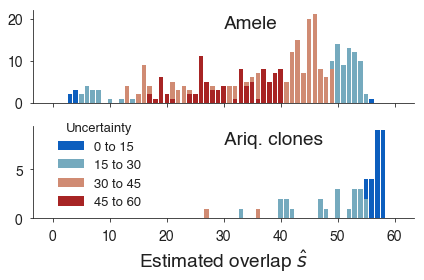

In [46]:
clr3 = pal.cmocean.diverging.Balance_7.mpl_colors
clr3[3] = clr3[4]
clr3[4] = clr3[5]
bands = np.arange(0,46,15)
bands = np.transpose(np.array([bands,bands+15]))
# samples = ["ari","ari2","brazil","ame","kilifi","thies"]
# names = ["Ariquemes clones", "Ariquemes isolates", "Brazil", "Amele", "Kilifi","Thies"]
samples = ["ame","ari"]
names = ["Amele", "Ariq. clones"]
fig,axs = plt.subplots(2,1,figsize=(6,4))
for ids,sample in enumerate(samples):
    ax = axs[ids]
    df = pd.DataFrame(data={"bro":bro[sample], "unc":lci[sample]})
    binz = np.arange(0,61)
    for idx,b in enumerate(bands):
        h = np.histogram(df.loc[(df["unc"]>b[0]) & (df["unc"]<=b[1]),"bro"].values,bins=(np.arange(0,62)-0.5))[0]
        ax.bar(binz,h,color=clr3[idx+1],label="{} to {}".format(b[0],b[1]))
#         ax.bar(binz,h,color=clr[2],label=str(b))
    yscale = ax.get_ylim()
    ax.text(30,0.8*yscale[1],"{}".format(names[ids]),size=19)
    if ids==0:
        finalize(ax,ignoreLegend=True)
        ax.set_xticklabels([])
#         ax.set_ylabel('count',labelpad=12)
    else:
        finalize(ax,ignoreLegend=True)
        leg = ax.legend(frameon=False,title="Uncertainty",loc=[0.05,0.05],fontsize=13)
        ax.set_xlabel("Estimated overlap $\hat{s}$")
        plt.setp(leg.get_title(),fontsize=13)
#         ax.set_ylabel('count')
    ax.yaxis.label.set_size(19)
    ax.xaxis.label.set_size(19)    
plt.tight_layout()
plt.savefig('figures/amele_thies_uncertainty.pdf'.format(sample))

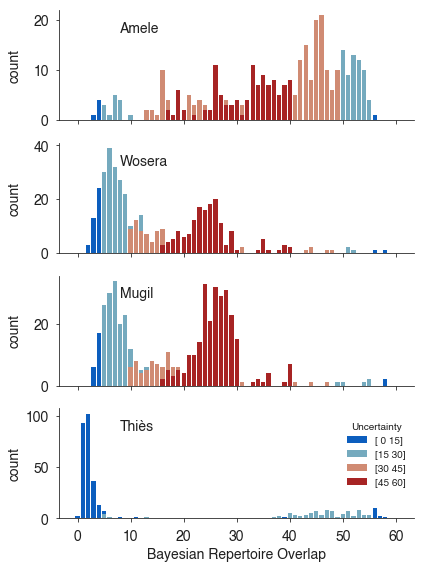

In [388]:
clr3 = pal.cmocean.diverging.Balance_7.mpl_colors
clr3[3] = clr3[4]
clr3[4] = clr3[5]
bands = np.arange(0,46,15)
bands = np.transpose(np.array([bands,bands+15]))
# samples = ["ari","ari2","brazil","ame","kilifi","thies"]
# names = ["Ariquemes clones", "Ariquemes isolates", "Brazil", "Amele", "Kilifi","Thies"]
samples = ["amele_tessema","wosera","mugil","thies"]
names = ["Amele", "Wosera","Mugil","Thiès"]
fig,axs = plt.subplots(4,1,figsize=(6,8))
for ids,sample in enumerate(samples):
    ax = axs[ids]
    df = pd.DataFrame(data={"bro":bro[sample], "unc":lci[sample]})
    binz = np.arange(0,61)
    for idx,b in enumerate(bands):
        h = np.histogram(df.loc[(df["unc"]>b[0]) & (df["unc"]<=b[1]),"bro"].values,bins=(np.arange(0,62)-0.5))[0]
        ax.bar(binz,h,color=clr3[idx+1],label=str(b))
#         ax.bar(binz,h,color=clr[2],label=str(b))
    yscale = ax.get_ylim()
    ax.text(8,0.8*yscale[1],"{}".format(names[ids]),size=14)
    if ids!=3:
        finalize(ax,ignoreLegend=True)
        ax.set_xticklabels([])
        ax.set_ylabel('count',labelpad=12)
    else:
        finalize(ax,ignoreLegend=True)
        leg = ax.legend(frameon=False,title="Uncertainty",loc=[0.8,0.25])
        ax.set_xlabel("Bayesian Repertoire Overlap")
        ax.set_ylabel('count')
plt.tight_layout()
plt.savefig('figures/uncertainty_barcharts.pdf'.format(sample))

# Bits

In [35]:
def logp_nab_given_c(s,c,pool=60):
    pna = np.log(p_ccp(c))
    pnb = np.log(p_ccp(c))
    nas = np.arange(1,len(pna))
    nbs = np.arange(1,len(pnb))
    logp_gen = np.full((pool+1,pool+1,pool+1), -np.inf)
    for na in nas:
        logp_sa = hypergeom.logpmf(np.arange(pool+1),pool,s,na)
        for nb in nbs:
            logpna_pnb = pna[na] + pnb[nb] # + for log
            for nab in range(0,np.minimum(na,nb)):
                logp_nab_given_sa = hypergeom.logpmf(nab,pool,np.arange(pool+1),nb)
                logp_nab_given_s = logsumexp(logp_nab_given_sa + logp_sa)
#                 logp_nab_given_s = np.log(np.dot(p_sa,p_nab_given_sa))
                logp_gen[na,nb,nab] = logp_nab_given_s + logpna_pnb # + for log
    return logp_gen